In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
current_path = '/content/drive/My Drive/Colab Notebooks/Project_GANder/gankook_cuda/semantic-segmentation-pytorch/pytorch_room_layout/'

import os
os.chdir(current_path)
!ls

build		      features		     segment_lsun.py
cv2_requirements.txt  info.json		     segment_rl.py
datasets	      lsun.pth.tar	     segment_st.py
data_transforms.py    lu_vp_detect.egg-info  sunrgbd.pth.tar
dist		      pics		     test_result
drn_d_105_024_val     __pycache__	     Vanish_Point_Detection
drn_d_105_024_val_ms  README.md		     visualize.m
drn.py		      requirements.txt	     XiaohuLuVPDetection


### Get Vanishing point, inliers

In [3]:
# !python XiaohuLuVPDetection/setup.py build
# !python XiaohuLuVPDetection/setup.py install
!pip install -r cv2_requirements.txt

     |████████████████████████████████| 25.4MB 1.4MB/s 
     |████████████████████████████████| 31.2MB 195kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
import cv2
cv2.__version__

'4.0.0'

### pytorch.room.layout

In [ ]:
# !pip install -r requirements.txt
# !apt install octave

In [ ]:
# import torch
# torch.__version__

In [ ]:
# !python segment_rl.py train -d datasets/lsun/ -c 4 -s 480 --arch drn_d_105 --batch-size 32 --random-scale 1.75 --random-rotate 15 --epochs 100 --lr 0.01 --momentum 0.9 --lr-mode poly --pretrained sunrgbd.pth.tar

In [ ]:
# !python segment_st.py test -d datasets/sunrgbd/ -c 37 --arch drn_d_105 -s 480 --resume sunrgbd.pth.tar --phase val --batch-size 1 --ms

In [ ]:
# !python segment_lsun.py test -d ../mask_data/wall/ -o ../mask_layout_data/wall/ -c 4 --arch drn_d_105 -s 320 --resume lsun.pth.tar --phase test --batch-size 1 --ms

### Functions

In [5]:
#             Detect Intersection             #
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sympy import Line
from sympy.geometry import Ray


def drawLines(img, lines, color=(255,255,255)):
    """
    Draw lines on an image
    """
    for line in lines:
        for rho,theta in line:
          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a*rho
          y0 = b*rho
          x1 = int(x0 + 1000*(-b))
          y1 = int(y0 + 1000*(a))
          x2 = int(x0 - 1000*(-b))
          y2 = int(y0 - 1000*(a))

          slope = (y1 - y0) / float(x1 - x0)
          angle = math.degrees(math.atan(slope))
          # if abs(angle) < 70:
          cv2.line(img, (x1,y1), (x2,y2), color, 1)

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection2(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


def regression(img, x, y, color=(0, 0, 0), axis=1):

  if axis == 1:
    y_at_border = np.array([0, img.shape[0]])
    p = np.polyfit(y, x, deg=1)
    x_at_border = np.poly1d(p)(y_at_border)
  else:
    x_at_border = np.array([0, img.shape[1]])
    p = np.polyfit(x, y, deg=1)
    y_at_border = np.poly1d(p)(x_at_border)

  cv2.line(img, (int(x_at_border[0]), int(y_at_border[0])), (int(x_at_border[1]), int(y_at_border[1])), color, 2)

  return x_at_border, y_at_border


def find_reg_points(img, lines, color=(255,0,0), drawlines=False):

  centroids = list()
  r_xs = list()
  r_ys = list()
  for line_ in lines:
      for rho,theta in line_:
          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a*rho
          y0 = b*rho
          x1 = int(x0 + 1000*(-b))
          y1 = int(y0 + 1000*(a))
          x2 = int(x0 - 1000*(-b))
          y2 = int(y0 - 1000*(a))

          slope = (y1 - y0) / float(x1 - x0)
          angle = math.degrees(math.atan(slope))
          if abs(angle) > 80:
            # print(img.shape[1])
            h_layout = line((0, 0), (img.shape[1], 0))
            h_layout_lower = line((0, img.shape[0]), (img.shape[1], img.shape[0]))
            r = intersection2(h_layout, line((x1, y1), (x2, y2)))
            r_lower = intersection2(h_layout_lower, line((x1, y1), (x2, y2)))
            # cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

            center_p = (int((r[0] + r_lower[0]) / 2), int((r[1] + r_lower[1])/ 2))
            centroids.append(center_p)

            r_xs.append((r[0], r_lower[0]))
            r_ys.append((r[1], r_lower[1]))

            if drawlines:
              cv2.line(img, (int(r[0]), int(r[1])), (int(r_lower[0]), int(r_lower[1])), color, 2)
              cv2.circle(img, center_p, 10, (255, 0, 255), -1)

  if drawlines:
    cv2.line(img, (int(0), int(0)), (int(0), int(img.shape[0])), color, 2)
    cv2.line(img, (int(img.shape[1]), int(0)), (int(img.shape[1]), int(img.shape[0])), color, 2)
    cv2.circle(img, (0, int(img.shape[0] / 2)), 10, (255, 0, 255), -1)
    cv2.circle(img, (img.shape[1], int(img.shape[0] / 2)), 10, (255, 0, 255), -1)
  centroids.append((0, int(img.shape[0] / 2)))
  centroids.append((img.shape[1], int(img.shape[0] / 2)))

  return r_xs, r_ys, centroids   

from scipy.spatial import distance as sci_dist

def order_points(pts):

  xSorted = pts[np.argsort(pts[:, 0]), :]
  leftMost = xSorted[:2, :]
  rightMost = xSorted[2:, :]
  leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
  (tl, bl) = leftMost
  D = sci_dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
  (br, tr) = rightMost[np.argsort(D)[::-1], :]

  return np.array([tl, tr, br, bl], dtype="float32")



image_index : 3
720x480_20200131153356598_gnIdiy35s8.png
scale_factor : 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


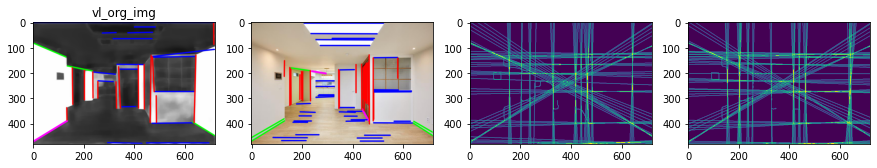

len(r_x_list), len(r_y_list) : 9 9
centroids_data.shape : (11, 1)
k is 4
[0 0 0 0 1 1 2 0 0 3 0]
keys : [1, 2]
reg_xs : [array([214.28064032, 210.07853927]), array([441.63131566, 433.22711356])]
sorted_index : [0, 1]
reg_xs : [array([214.28064032, 210.07853927]), array([441.63131566, 433.22711356])]
reg_index, reg_x, reg_y : 0 [214.28064032 210.07853927] [  0 480]
middle vline
max_x, min_x : 441.6313156578287 210.07853926963483


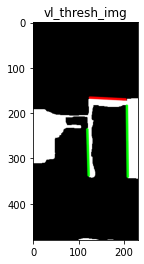

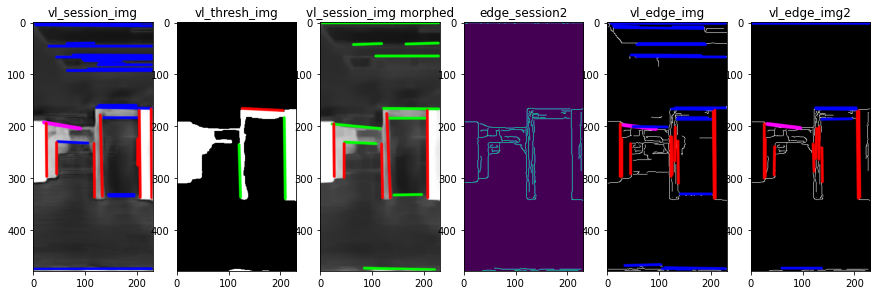

#        Original vl list        #
len(left_vl_list) : 0
len(right_vl_list) : 1

mean_right_angle : 2.786364139811296
right_angle : [2.786364139811296]

#          Extended vl list left / right  TB Condition        #
len(ex_left_top_vl) : 0
len(ex_left_bot_vl) : 0
len(ex_right_top_vl) : 1
len(ex_right_bot_vl) : 0

thr_session_gray.shape : (480, 231)
max_y_coord : (227, 344)
angle : -2.786325522568391
right_bottest_vl : (0.0, 355.0478463532572, 231.0, 343.80532429333465)

#          Warping Points        #
src : [[  0.   0.]
 [231.   0.]
 [231. 480.]
 [  0. 480.]]
dst : [[  0.      160.82677]
 [231.      172.06929]
 [231.      343.80533]
 [  0.      355.04785]]


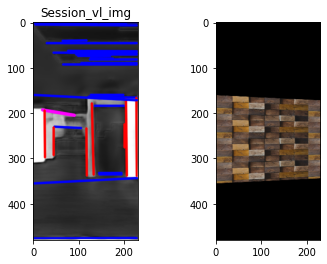

iter : True
max_x, min_x : 214.28064032016005 0


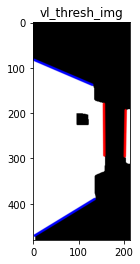

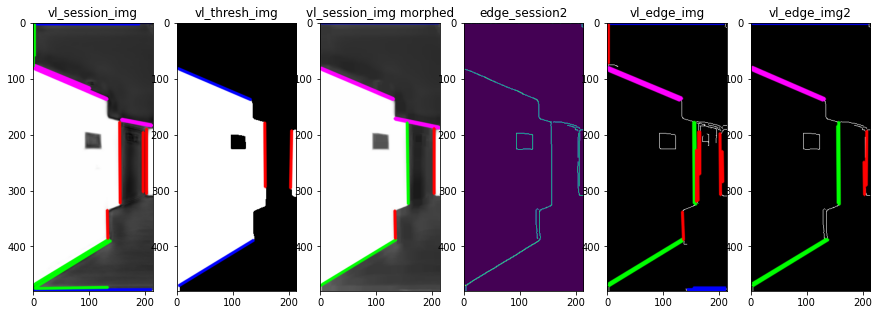

#        Original vl list        #
len(left_vl_list) : 0
len(right_vl_list) : 2

mean_right_angle : 27.124253347458943
right_angle : [22.87576315951187, 31.372743535406016]

#          Extended vl list left / right  TB Condition        #
len(ex_left_top_vl) : 0
len(ex_left_bot_vl) : 0
len(ex_right_top_vl) : 1
len(ex_right_bot_vl) : 1

thr_session_gray.shape : (480, 214)

#          Warping Points        #
src : [[  0.   0.]
 [214.   0.]
 [214. 480.]
 [  0. 480.]]
dst : [[  0.       82.65738]
 [214.      172.9484 ]
 [214.      342.47995]
 [  0.      472.96655]]


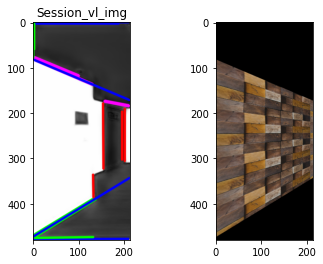

reg_index, reg_x, reg_y : 1 [441.63131566 433.22711356] [  0 480]
reg_index = len(reg_xs) - 1
max_x, min_x : 720 433.227113556778


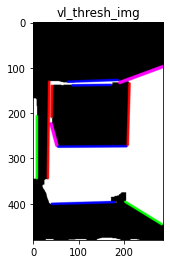

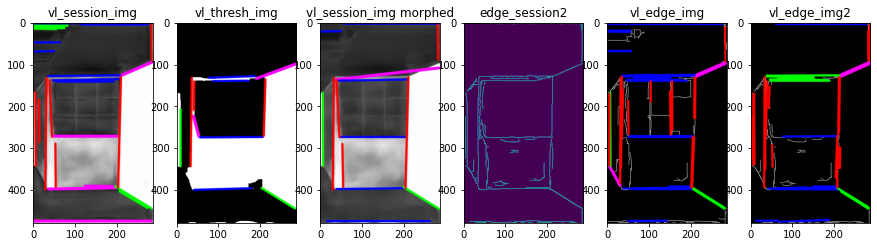

#        Original vl list        #
len(left_vl_list) : 4
len(right_vl_list) : 2

mean_left_angle : 13.71096070249719
left_angle : [20.460277328304134, 2.012849903677496, 0.6338392666081534, 31.73687631139898]
mean_right_angle : 0.8838502688698331
right_angle : [0.2772255594996917, 1.4904749782399744]

#          Extended vl list left / right  TB Condition        #
len(ex_left_top_vl) : 3
len(ex_left_bot_vl) : 1
len(ex_right_top_vl) : 0
len(ex_right_bot_vl) : 2

thr_session_gray.shape : (480, 287)
min_y_coord : (285, 97)
angle : 1.4598851889358477
right_toppest_vl : (0.0, 89.73668417540533, 287.0, 97.05097063736558)

#          Warping Points        #
src : [[  0.   0.]
 [287.   0.]
 [287. 480.]
 [  0. 480.]]
dst : [[  0.      204.41118]
 [287.       97.3326 ]
 [287.      448.66068]
 [  0.      271.2524 ]]


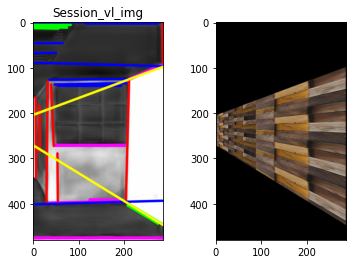

elapsed time : 6.78085994720459



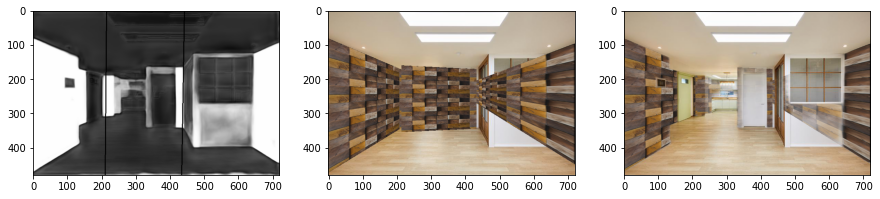

In [6]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from XiaohuLuVPDetection.lu_vp_detect.vp_detection import VPDetection
import time
# import os
import cv2
# import pylab as pl
from skimage import morphology as mp
import sys
from Vanish_Point_Detection import wrapper


length_thresh = 50
principal_point = None
focal_length = 1300 # 1102.79
seed = 1300
vpd = VPDetection(length_thresh, principal_point, focal_length, seed)

org_path = 'datasets/lsun/images/' # -> original image
layout_path = 'drn_d_105_024_val_ms/images/' # -> layout image (result image frome above model file)
refer_path = '../refer_data/wall/myxkehu1kfzggursepnk0tfiyps8zbs5umvzv8d92r6hhxejgawebwsufssgov5q-.jpg'

object_ = 'wall'
mask_path = '../mask_data/' + object_ + '/'
# layout_path = '../test_layout_result/' + object_ + '/'
layout_path = '../mask_layout_data/' + object_ + '/'
# refer_path = './refer_data/' + object_ + '/'

val_image_list = os.listdir(layout_path)

one_iter = False
start_index = 0
for image_index, image in enumerate(val_image_list):

  if image_index < start_index:
    continue
  image = '720x480_20200131153356598_gnIdiy35s8.png'
  print('image_index :', val_image_list.index(image))
  one_iter = True

  # print(image)
  img = Image.open(layout_path + image)
  # print(type(img))
  img_np = np.invert(np.asarray(img))
  # print(img_np.max(), img_np.min())
  ret, thr = cv2.threshold(img_np, 254, 255, cv2.THRESH_BINARY_INV)

  org = Image.open(mask_path + image)
  org_color_np, org_np = np.split(np.asarray(org), 2, axis=1)
  # org_np = np.asarray(org)
  # gray = cv2.cvtColor(org_np, cv2.COLOR_RGB2GRAY)
  # print(org_np.shape)
  # ret, thr = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)


  print(image)
  # plt.subplot(131)
  # plt.imshow(org)
  # plt.show()
  img_size = (org_np.shape[1], org_np.shape[0])
  
  scale_factor = 6
  print('scale_factor :', scale_factor)

  refer = Image.open(refer_path)
  refer = np.asarray(refer)

  #     refer_size와 img_size가 동일하거나 refer_size가 작은 경우를 고려해야한다.     #
  refer = np.tile(refer, (scale_factor, scale_factor, 1))
  size_ratio = math.floor(min((refer.shape[0] / (org_np.shape[0] * 1.5)), (refer.shape[1] / (org_np.shape[1] * 1.5))))
  refer = Image.fromarray(refer).resize((int(refer.shape[1] / size_ratio), int(refer.shape[0] / size_ratio)))

  tun = thr
  skl = mp.medial_axis(tun).astype(np.uint8) * 255
  rho = 1
  theta = np.pi/180
  thresh = 50
  # print(skl.shape, skl.dtype)

  # lines = cv2.HoughLines(org_np.astype(np.uint8), rho, theta, thresh)
  lines = cv2.HoughLines(skl, rho, theta, thresh)

  # print(lines)
  # plt.imshow(skl)
  # plt.show()

  # Draw all Hough lines in red
  # img_with_all_lines = np.copy(skl)
  # img_with_all_lines = cv2.cvtColor(img_with_all_lines, cv2.COLOR_GRAY2RGB)
  # plt.imshow(img_with_all_lines)
  # plt.show()
  org_color_np2 = org_color_np.copy()
  org_np = org_np.astype(np.uint8)
  org_np2 = org_np.copy()
  org_np3 = org_np.copy()

  start = time.time()

  r_x_list, r_y_list, centroids_list = find_reg_points(org_np, lines,)
  # drawLines(img_with_all_lines, lines)

  #     Edit Your Mask     #
  kernel = np.ones((10, 10), np.uint8)
  
  # plt.figure(figsize=(20, 15))
  # for plot_i in range(5):
  #   plt.subplot(1, 5, plot_i+1)
  #   if plot_i == 0:
  #     plt.imshow(org_np2)
  #   elif plot_i == 1: #      Dilation     #
  #     plt.imshow(cv2.dilate(org_np2, kernel, iterations=1))
  #   elif plot_i == 2: #      Closing      #
  #     plt.imshow(cv2.morphologyEx(org_np2, cv2.MORPH_CLOSE, kernel))
  #   elif plot_i == 3: #     Erode     #
  #     plt.imshow(cv2.erode(org_np2, kernel, iterations=1))
  #   elif plot_i == 4: #     Opening   #
  #     plt.imshow(cv2.morphologyEx(org_np2, cv2.MORPH_OPEN, kernel))
  # plt.show()

  org_np2_morp = cv2.morphologyEx(org_np2, cv2.MORPH_CLOSE, kernel)
  org_np2_copy = org_np2_morp.copy()
  org_np2_copy_gray = cv2.cvtColor(org_np2_copy, cv2.COLOR_RGB2GRAY)

  vpd.find_vps(org_np2_morp)
  vps = vpd.vps_2D
  vl_org_img, vl_list = vpd.create_debug_VP_image()

  vpd.find_vps(org_color_np)
  vps = vpd.vps_2D
  vl_color_img, _ = vpd.create_debug_VP_image()

  edge_org_np2 = cv2.Canny(org_np2_morp, 30, 300)
  edge_org_np2_copy = edge_org_np2.copy()
  edge_org_np2_copy2 = cv2.Canny((org_np2_copy / 255. * org_np2_copy).astype(np.uint8), 30, 300)

  vpd.find_vps(edge_org_np2)
  # vps = vpd.vps_2D
  edge_vl_img, vl_list = vpd.create_debug_VP_image()

  #             Hough Lines Detection           #
  # print('org_np2.dtype :', org_np2.dtype)
  # print('org_np2.shape :', org_np2.shape)
  # plt.imshow(org_np2_copy_gray)
  # plt.show()
  # lines = cv2.HoughLines(org_np2_copy_gray, rho, theta, thresh)
  # drawLines(org_np2_copy_gray, lines)
  # plt.imshow(edge_org_np2_copy)
  # plt.show()
  edge_lines = cv2.HoughLines(edge_org_np2_copy, rho, theta, thresh)
  drawLines(edge_org_np2_copy, edge_lines)
  # plt.imshow(edge_org_np2_copy2)
  # plt.show()
  edge_lines2 = cv2.HoughLines(edge_org_np2_copy2, rho, theta, thresh)
  drawLines(edge_org_np2_copy2, edge_lines2)
  # vl_color_img, vps, vpssum = wrapper.dealAImage(org_color_np, True, True, True, True, Ostandard=True)

  # print(vps)
  # print('vps :', vps)
  # right_vp = vps[0]
  # color = (255, 0, 255)
  # cv2.circle(vl_color_img, (int(right_vp[0]), int(right_vp[1])), 50, (255, 0, 255), -1)
  # # cv2.line(vl_org_img, (0, 0), (int(right_vp[0]), int(right_vp[1])), color, 5)
  # # cv2.line(vl_org_img, (0, vl_org_img.shape[0]), (int(right_vp[0]), int(right_vp[1])), color, 5)
  # left_vp = vps[1]
  # color = (255, 0, 0)
  # cv2.circle(vl_color_img, (int(left_vp[0]), int(left_vp[1])), 50, (255, 0, 255), -1)
  # # cv2.line(vl_org_img, (vl_org_img.shape[1], 0), (int(left_vp[0]), int(left_vp[1])), color, 5)
  # # cv2.line(vl_org_img, (vl_org_img.shape[1], vl_org_img.shape[0]), (int(left_vp[0]), int(left_vp[1])), color, 5)
  
  plt.figure(figsize=(15, 10))
  plt.subplot(141)
  plt.imshow(vl_org_img)
  plt.title('vl_org_img')

  plt.subplot(142)
  # plt.imshow(org_color_np)
  plt.imshow(vl_color_img)

  plt.subplot(143)
  plt.imshow(edge_org_np2_copy)

  plt.subplot(144)
  plt.imshow(edge_org_np2_copy2)
  plt.show()

  centroids_data = np.array(centroids_list)[:, [0]]
  print('len(r_x_list), len(r_y_list) :', len(r_x_list), len(r_y_list))
  print('centroids_data.shape :', centroids_data.shape)
  mms = MinMaxScaler()
  cen_data =mms.fit_transform(centroids_data)
  # print('cen_data :', cen_data)
  K = range(2, 6)
  s_dist = list()
  for k in K:
    if cen_data.shape[0] < k:
      break
    km = KMeans(n_clusters=k)
    km = km.fit(cen_data)
    inertia = km.inertia_
    s_dist.append(inertia)
    
    # if inertia <= 0:
    #   print('vertical line number =', k)
    #   break
  mms2 = MinMaxScaler()
  mms_s_dist = mms2.fit_transform(np.array(s_dist).reshape(-1, 1))
  k_thresh = 0.1
  # plt.plot(range(len(mms_s_dist)), mms_s_dist)
  # plt.show()

  if cen_data.shape[0] > 2:
    for i in range(len(mms_s_dist)):
      if mms_s_dist[i] < k_thresh:
        k = i + 2
        break
  else:
    k = 2

  #     k Confirmation : Comparing k.cluster_centers_ dist  #
  while True:    

    km = KMeans(n_clusters=k)
    km = km.fit(cen_data)
    if k <= 2:
      break

    cluster_centroids = km.cluster_centers_
    # print('cluster_centroids :', cluster_centroids)
    error_exist = False
    for i in range(len(cluster_centroids) - 1):
      for j in range(i + 1, len(cluster_centroids)):
        if abs(cluster_centroids[i] - cluster_centroids[j]) < 0.05:
          error_exist = True
    if error_exist:
      k -= 1
    else:
      break

  print('k is', k)

  predict_cen = km.predict(cen_data)
  print(predict_cen)

  keys = list(range(k))
  for rm in predict_cen[-2:]:
    keys.remove(rm)
  print('keys :', keys)

  skl_rgb = cv2.cvtColor(skl, cv2.COLOR_GRAY2RGB)
  skl_copy = np.copy(skl_rgb)

  # black_plane = np.zeros(skl_rgb.shape).astype(np.uint8)
  black_plane2 = np.zeros(skl_rgb.shape).astype(np.uint8)

  
  reg_xs = list()
  reg_ys = list()
  for key in keys:
    temp_rx = tuple()
    temp_ry = tuple()
    for pred_key, r_x, r_y in zip(predict_cen[:-2], r_x_list, r_y_list):
      if key == pred_key:
        temp_rx += r_x
        temp_ry += r_y

    #       Regression Multiple Lines     #
    border_x, border_y = regression(org_np3, temp_rx, temp_ry)
    # regression(black_plane, temp_rx, temp_ry)
    # print(border_x, border_y)

    reg_xs.append(border_x)
    reg_ys.append(border_y)

  print('reg_xs :', reg_xs)
  
  
  center_xs = list()
  for reg_x in reg_xs:
    #     all_closest_inter가 정렬되지 않았다면 inters type = list()      #
    # sum_x = 0
    # for inter in inters:
    #   sum_x += inter[0] + inter[2]
    center_xs.append(np.mean(reg_x))
  sorted_center_xs = sorted(center_xs)

  sorted_index = list()
  for center_x in sorted_center_xs:
    # print('center_x :', center_x)
    sorted_index.append(center_xs.index(center_x))
  print('sorted_index :', sorted_index)
  #       sorted_center_xs 순서로 all_closest_inter를 정렬한다.     #
  #       index list를 추출해서 for 문으로 all_closest_inter의 inters를 추출해
  #       sorted_all ... 에 append 시킨다.      #

  sorted_reg_xs = list()
  sorted_reg_ys = list()
  for s_index in sorted_index:
    sorted_reg_xs.append(reg_xs[s_index])
    sorted_reg_ys.append(reg_ys[s_index])
  reg_xs = sorted_reg_xs
  reg_ys = sorted_reg_ys

  print('reg_xs :', reg_xs)

  #           VL Segmentation             #
  # Angle between line1 and x-axis
  # print(len(vl_list))

  # print('len(v_lines) :', len(v_lines))
  # print('len(h_lines) :', len(h_lines))
  
  #         Extend v_lines and draw h_lines       #
  h_border = line((0, 0), (skl_copy.shape[1], 0))
  h_border_lower = line((0, skl_copy.shape[0]), (skl_copy.shape[1], skl_copy.shape[0]))

  #     vline 이 존재하지 않는 경우도 고려해야한다.     #
  if len(reg_xs) == 0:
    reg_xs.append([0, 0])
    reg_ys.append([0, org_np2.shape[0]])
    
  #         Divide Session by vline       #
  for reg_index, (reg_x, reg_y) in enumerate(zip(reg_xs, reg_ys)):


    #     In a Session     #
    #     1.  find vanishing point    #
    #     2.  Find 3 points (vp, top & bottom points)     #
    #     3.  Do warfine and attach to the black plane      #

    print('reg_index, reg_x, reg_y :', reg_index, reg_x, reg_y)
    
    #     0.  crop by vline     #
          #   Find Max_x, min_x, (Max_y, min_y = org.shape[0], 0)
          #   1.    우편에 한해서 max_x = 우편 vline max_x & min_x = 현재 vline min_x
          #   2.    좌편에 한해서 max_x = 현재 Max_x & min_x = 좌편 vline min_x

    #      vline 별로 양옆으로 작업을 하면 len(vline) = 1의 작업을 반복할 필요가 없어진다.    #
    iter = False
    while True:

      #                   We need Max, min x & y                #
      # four_inters = list()
      find_pair = True
      # centroid_inters = all_centroid_inters[inters_i]

      if not iter:
        #       vline 우측 session      #
        # print(final_xs)
        # four_inters.append([final_xs[0], final_ys[0]])
        # four_inters.append(centroid_inters[0])
        # print(four_inters)

        #       오른쪽 끝 vline 이면        #
        if reg_index == len(reg_xs) - 1:
          print('reg_index = len(reg_xs) - 1')
          #   1.    우편에 한해서 max_x = 우편 vline max_x & min_x = 현재 vline min_x
          max_x = org_np.shape[1]
          min_x = np.min(reg_x)

        else:
          print('middle vline')
          next_reg_x = reg_xs[reg_index + 1]
          max_x = np.max(next_reg_x)
          min_x = np.min(reg_x)

      #     i = 0 에 한해서만 왼쪽으로도 refering 진행, 나머지는 오른쪽으로만     #
      else:
          #   2.    좌편에 한해서 max_x = 현재 Max_x & min_x = 좌편 vline min_x
          max_x = np.max(reg_x)
          min_x = 0

      print('max_x, min_x :', max_x, min_x)
      # max_y = org_np.shape[0]
      # min_y = 0

      #     Make Session      #
      session = org_np2[:, int(min_x):int(max_x)]

      vpd.find_vps(session)
      # vps = vpd.vps_2D
      vl_img, vl_list = vpd.create_debug_VP_image(show_vl=True)


      #       Closing Morphing by OpenCV      #
      kernel = np.ones((10, 10), np.uint8)
      session = cv2.morphologyEx(session, cv2.MORPH_CLOSE, kernel)

      vpd.find_vps(session)
      # vps = vpd.vps_2D
      vl_session_img, vl_session_list = vpd.create_debug_VP_image(show_vl=True)

      #     Feed Binary inv Threshold     #      
      # gray = cv2.cvtColor(session, cv2.COLOR_RGB2GRAY)
      ret, thr_session = cv2.threshold(session, 127, 255, cv2.THRESH_BINARY)
      thr_session = cv2.morphologyEx(thr_session, cv2.MORPH_CLOSE, kernel)
      thr_session_copy = thr_session.copy()
      vpd.find_vps(thr_session_copy)
      # vps = vpd.vps_2D
      vl_thresh_img, vl_thresh_list = vpd.create_debug_VP_image(show_vl=True)

      plt.imshow(vl_thresh_img)
      plt.title('vl_thresh_img')
      plt.show()

      #       Edge Session      #
      #     Multiply mask map with Edge => Erase Unnecessary vl line    #
      edge_session = cv2.Canny(session, 20, 60)

      #     Before Canny    #
      session_prob = session / 255.

      #   multiply one time   #
      session2 = session_prob * (session)
      edge_session2 = cv2.Canny(session2.astype(np.uint8), 20, 60)

      #       two time      #
      # session2 = session_prob**2 * (session)
      # edge_session2 = cv2.Canny(session2.astype(np.uint8), 20, 60)

      vpd.find_vps(edge_session)
      # vps = vpd.vps_2D      
      vl_edge_img, vl_edge_list = vpd.create_debug_VP_image(show_vl=True)

      vpd.find_vps(edge_session2)
      # vps = vpd.vps_2D      
      vl_edge_img2, vl_edge_list2 = vpd.create_debug_VP_image(show_vl=True)
      

      # session = wrapper.dealAImage(session,True,True,True)

      # #             color             #
      # session = org_color_np[:, int(min_x):int(max_x)]

      #       Use made vl_img (get more vn_lines)     #
      # session = vl_org_img[:, int(min_x):int(max_x)]

      

      plt.figure(figsize=(15, 10))
      plt.subplot(161)
      plt.imshow(vl_img)
      plt.title('vl_session_img')

      plt.subplot(162)
      plt.imshow(vl_thresh_img)
      plt.title('vl_thresh_img')

      plt.subplot(163)
      plt.imshow(vl_session_img)
      plt.title('vl_session_img morphed')

      plt.subplot(164)
      plt.imshow(edge_session2)
      plt.title('edge_session2')

      plt.subplot(165)
      plt.imshow(vl_edge_img)
      plt.title('vl_edge_img')

      plt.subplot(166)
      plt.imshow(vl_edge_img2)
      plt.title('vl_edge_img2')     
      # plt.imshow(vl_img)
      # plt.title('vl_img')
      plt.show()

      v_lines = list()
      h_lines = list()
      # print('vps :', vps)

      top_vl = list()
      bottom_vl = list()

      left_vl_list = list()
      right_vl_list = list()

      left_angle = list()
      right_angle = list()

      #         What is best vl_list      #
      vl_list = vl_thresh_list

      for vl in vl_list:
        x0, y0, x1, y1 = vl
        slope = (y1 - y0) / float(x1 - x0)
        angle = math.degrees(math.atan(slope))
        # print(angle)
        # if abs(angle) > 80:
        #   # cv2.line(skl_copy, (int(x1), int(y1)), (int(x0), int(y0)), (255, 0, 0), 3,
        #   #                  cv2.LINE_AA)
        #   v_lines.append(vl)

        if abs(angle) < 70:
          if (y0 + y1) / 2 < vl_img.shape[0] / 2:
            # print(y0, y1)
            top_vl.append(vl)
            if angle < 0:
              left_vl_list.append(vl)
              left_angle.append(abs(angle))
            else:
              right_vl_list.append(vl)
              right_angle.append(abs(angle))
          else:
            bottom_vl.append(vl)
            if angle > 0:
              left_vl_list.append(vl)
              left_angle.append(abs(angle))
            else:
              right_vl_list.append(vl)
              right_angle.append(abs(angle))
          # cv2.line(skl_copy, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 2,
          #                  cv2.LINE_AA)
          h_lines.append(vl)
        #   regression(vl_img, (x0, x1), (y0, y1), color=(0,255,255),axis=1)
      print('#        Original vl list        #')
      print('len(left_vl_list) :', len(left_vl_list))
      print('len(right_vl_list) :', len(right_vl_list))
      print()

      #             Delete over standarded angle vl             #
      if len(left_vl_list) != 0:
        copy_left_vl_list = left_vl_list.copy()
        copy_left_angle = left_angle.copy()
        mean_left_angle = np.array(left_angle).mean()
        print('mean_left_angle :', mean_left_angle)
        print('left_angle :', left_angle)

        for angle_index, angle in enumerate(copy_left_angle):
          if abs(angle - mean_left_angle) > 20:
            left_vl_list.remove(copy_left_vl_list[angle_index])
            left_angle.remove(copy_left_angle[angle_index])
        # standardScaler = StandardScaler()
        # std_left_angle = standardScaler.fit_transform(np.array(left_angle).reshape(-1, 1))
        # print('standardScaler.fit_transform(left_angle) :', std_left_angle)
        # print('left_angle :', left_angle)        

        # for std_index, std_angle in enumerate(std_left_angle):
        #   if abs(std_angle) > 2:
        #     left_vl_list.remove(copy_left_vl_list[std_index])
            # left_angle.remove(copy_left_angle[std_index])

        # print('left_angle :', left_angle)

      if len(right_vl_list) != 0:
        copy_right_vl_list = right_vl_list.copy()
        copy_right_angle = right_angle.copy()
        mean_right_angle = np.array(right_angle).mean()
        print('mean_right_angle :', mean_right_angle)
        print('right_angle :', right_angle)

        for angle_index, angle in enumerate(copy_right_angle):
          if abs(angle - mean_right_angle) > 20:
            right_vl_list.remove(copy_right_vl_list[angle_index])
            right_angle.remove(copy_right_angle[angle_index])

      
      # top_condition = False
      # bot_condition = False
      # for vl in left_vl_list:
      #   if vl in top_vl:
      #     top_condition = True
      #   elif vl in bottom_vl:
      #     bot_condition = True
      # if top_condition and bot_condition:
      #   pass
      # else:
      #   left_vl_list = list()
      #   print('left top bot condition False')
      #   print('top_condition :', top_condition)
      #   print('bot_condition :', bot_condition)

      # top_condition = False
      # bot_condition = False
      # for vl in right_vl_list:
      #   # print('vl :', vl)
      #   if vl in top_vl:
      #     top_condition = True
      #   elif vl in bottom_vl:
      #     bot_condition = True
      # if top_condition and bot_condition:
      #   pass
      # else:
      #   right_vl_list = list()
      #   print('right top bot condition False')
      #   print('top_condition :', top_condition)
      #   print('bot_condition :', bot_condition)
      
      # print('-- after --')
      # print('len(left_vl_list) :', len(left_vl_list))
      # print('len(right_vl_list) :', len(right_vl_list))
      # print()

      # for vl in vl_list:
      #   x0, y0, x1, y1 = vl

      #   # if right_gap < 30:
      #   #   left_vl_list.append(vl)
      #   #   print('right_angle :', angle)
      #   if vl in left_vl_list:
      #     regression(vl_img, (x0, x1), (y0, y1), color=(0,0,255),axis=1)
      #   # elif left_gap < 30:
      #   elif vl in right_vl_list:
      #     # right_vl_list.append(vl)
      #     # print('left_angle :', angle)
      #     regression(vl_img, (x0, x1), (y0, y1), color=(255,0,0),axis=1)
      if len(left_vl_list) == 0 and len(right_vl_list) == 0:
          #     i != 0 인 경우 break     #
        if reg_index == 0 and not iter:
          iter = True
          print('iter :', iter)
          continue

        else:
          break
        
      
      #                       Find External vn_line                     #
      h_border_top = Line((0, 0), (vl_img.shape[1], 0))
      h_border_bot = Line((0, vl_img.shape[0]), (vl_img.shape[1], vl_img.shape[0]))
      top_down_ratio = 0.66
      left_margin = 0.33
      right_margin = 1 - left_margin

      ex_left_top_vl = list()
      ex_left_bot_vl = list()
      ex_right_top_vl = list()
      ex_right_bot_vl = list()

      l2 = Line((0, 0), (0, vl_img.shape[0]))
      l3 = Line((vl_img.shape[1], 0), (vl_img.shape[1], vl_img.shape[0]))

      for vl in left_vl_list:
        x0, y0, x1, y1 = vl
        l1 = Line((x0, y0), (x1, y1))
        #     v_border line     #
        [left_point] = l1.intersection(l2)
        # print('left_point :', left_point)
        [right_point] = l1.intersection(l3)

        top_bot_pass = False
        try:
          [top_point] = l1.intersection(h_border_top)
          [bot_point] = l1.intersection(h_border_bot)
        except:
          top_bot_pass = True
        # print('top_point :', int(top_point[0]), int(top_point[1]))
        # print('bot_point :', int(bot_point[0]), int(bot_point[1]))

        #      Figure out current vl is top / bottom vl     #
        extend = False
        if vl in top_vl:
          #      line should have same height (y)     #
          if (left_point[1] < vl_img.shape[0] * top_down_ratio and right_point[1] < vl_img.shape[0] * top_down_ratio):
            #     h_border 와의 교차점 조건    #
            # if not top_bot_pass:
            # if top_point[0] >= vl_img.shape[1] * right_margin and bot_point[0] <= vl_img.shape[1] * left_margin:
              # extend = True
              ex_left_top_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))

        elif vl in bottom_vl:
          # print('vl in bottom at left :', vl)
          #      line should have same height (y)     #
          if (left_point[1] > vl_img.shape[0] * (1 - top_down_ratio) and right_point[1] > vl_img.shape[0] * (1 - top_down_ratio)):
            #     h_border 와의 교차점 조건    #
            # if not top_bot_pass:
            # if top_point[0] <= vl_img.shape[1] * left_margin and bot_point[0] >= vl_img.shape[1] * right_margin:
              # extend = True
              ex_left_bot_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))
          

      for vl in right_vl_list:
        x0, y0, x1, y1 = vl
        l1 = Line((x0, y0), (x1, y1))
        #     v_border line     #
     
        [left_point] = l1.intersection(l2)
        # print('left_point :', left_point)
        [right_point] = l1.intersection(l3)
        
        top_bot_pass = False
        try:
          [top_point] = l1.intersection(h_border_top)
          [bot_point] = l1.intersection(h_border_bot)
        except:
          top_bot_pass = True
        # print('top_point :', int(top_point[0]), int(top_point[1]))
        # print('bot_point :', int(bot_point[0]), int(bot_point[1]))

        #      Figure out current vl is top / bottom vl     #
        extend = False
        if vl in top_vl:
          #      line should have same height (y)     #
          if (left_point[1] < vl_img.shape[0] * top_down_ratio and right_point[1] < vl_img.shape[0] * top_down_ratio):
            #     h_border 와의 교차점 조건    #
            # if top_point[0] <= vl_img.shape[1] * left_margin and bot_point[0] >= vl_img.shape[1] * right_margin:
              # extend = True
              ex_right_top_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))


        elif vl in bottom_vl:
          # print('vl in bottom at right :', vl)
          #      line should have same height (y)     #
          if left_point[1] > vl_img.shape[0] * (1 - top_down_ratio) and right_point[1] > vl_img.shape[0] * (1 - top_down_ratio):
            #     h_border 와의 교차점 조건    #
            # if top_point[0] >= vl_img.shape[1] * right_margin and bot_point[0] <= vl_img.shape[1] * left_margin:
              # extend = True          
              ex_right_bot_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))

        # if extend:
        #   ex_right_vl.append((left_point[0], left_point[1], right_point[0], right_point[1]))
        # print('ex_left_vl[-1] :', ex_left_vl[-1])

      print()
      print('#          Extended vl list left / right  TB Condition        #')
      print('len(ex_left_top_vl) :', len(ex_left_top_vl))
      print('len(ex_left_bot_vl) :', len(ex_left_bot_vl))
      print('len(ex_right_top_vl) :', len(ex_right_top_vl))
      print('len(ex_right_bot_vl) :', len(ex_right_bot_vl))
      print()

      #       find min max Line     #
      max_y = 0
      right_bottest_vl = None
      min_y = vl_img.shape[0]
      right_toppest_vl = None

      for vl in ex_right_bot_vl:
        if vl[1] > max_y:
          right_bottest_vl = vl
          max_y = vl[1]
      
      for vl in ex_right_top_vl:
        if vl[1] < min_y:
          right_toppest_vl = vl
          min_y = vl[1]
      
      max_y = 0
      left_bottest_vl = None
      min_y = vl_img.shape[0]
      left_toppest_vl = None

      for vl in ex_left_bot_vl:
        if vl[3] > max_y:
          left_bottest_vl = vl
          max_y = vl[3]
      
      for vl in ex_left_top_vl:
        if vl[3] < min_y:
          left_toppest_vl = vl
          min_y = vl[3]


      #       Figure out min_y & max_y of thr_session       #
      # print('thr_session.shape :', thr_session.shape)
      
      #     바닥은 오히려 하면 안된다.    #
      thr_session_gray = cv2.cvtColor(thr_session, cv2.COLOR_RGB2GRAY)
      print('thr_session_gray.shape :', thr_session_gray.shape)

      top_white_cnt = 0
      bot_white_cnt = 0
      white_min_x = thr_session_gray.shape[1]
      white_max_x = 0
      white_min_y = thr_session.shape[0]
      white_max_y = 0
      temp_min_y = white_min_y
      temp_max_y = white_max_y
      top_parallel = False
      bot_parallel = False
      for i in range(thr_session_gray.shape[1]):

        #     Check Top Condition     #
        for j in range(int(thr_session_gray.shape[0] / 10)):
          # if thr_session_gray[j][i] == 255 and j < thr_min_y:
            # thr_min_y = j
            # thr_min_y_coord = (i, j)
          if thr_session_gray[j][i] == 255:
            top_white_cnt += 1
            if i > white_max_x:
              white_max_x = i
              max_x_coord = (i, j)
            if i < white_min_x:
              white_min_x = i
              min_x_coord = (i, j)
            if j < temp_min_y:
              temp_min_y = j
              temp_min_y_coord = (i, j)

        for j in range(int(thr_session_gray.shape[0] / 10), int(thr_session_gray.shape[0] * 9/10)):
          if thr_session_gray[j][i] == 255:
            if j > white_max_y:
              white_max_y = j
              max_y_coord = (i, j)
            if j < white_min_y:
              white_min_y = j
              min_y_coord = (i, j)

        #     Check Bot Condition   #
        for j in range(int(thr_session_gray.shape[0] * 9/10), thr_session_gray.shape[0]):
          # if thr_session_gray[j][i] == 255 and j < thr_min_y:
            # thr_min_y = j
            # thr_min_y_coord = (i, j)
          if thr_session_gray[j][i] == 255:
            bot_white_cnt += 1
            if j > temp_max_y:
              temp_max_y = j
              temp_max_y_coord = (i, j)
            # if i > white_max_x:
            #   white_max_x = i
            #   max_x_coord = (i, j)
            # if i < white_min_x:
            #   white_min_x = i
            #   min_x_coord = (i, j)

      if top_white_cnt / (thr_session_gray.shape[1] * int(thr_session_gray.shape[0] / 10)) > 0.5:
        top_parallel = True
        min_y_coord = temp_min_y_coord
      
      if bot_white_cnt / (thr_session_gray.shape[1] * int(thr_session_gray.shape[0] / 10)) > 0.5:
        bot_parallel = True
        max_y_coord = temp_max_y_coord

          # elif thr_session_gray[j][i] == 1 and j > thr_max_y:    
          #   thr_max_y = j
          #   thr_max_y_coord = (j, i)
      # print('thr_min_y :', thr_min_y)
      # print('thr_min_y_coord :', thr_min_y_coord)
      try:
        max_x_coord, min_x_coord
        print('max_x_coord, min_x_coord :', max_x_coord, min_x_coord)
      except:
        pass


      #     None 이라면 대칭이동을 통해 만들어주어야한다.     #
      if len(ex_right_bot_vl) == 0:
        if right_toppest_vl is not None:
          x0, y0, x1, y1 = right_toppest_vl
          slope = (y1 - y0) / float(x1 - x0)
          angle = - math.degrees(math.atan(slope))

          #       white_max_y 를 - toppest_vl angle 로 지나는 직선      #
          print('max_y_coord :', max_y_coord)
          print('angle :', angle)
          endy = 100 * math.sin(math.radians(angle))
          endx = 100 * math.cos(math.radians(angle))
          temp_vl = Line(max_y_coord, (max_y_coord[0] + endx, max_y_coord[1] + endy))
          [left_point] = temp_vl.intersection(l2)
          [right_point] = temp_vl.intersection(l3)
          # print('left_point :', left_point)
          right_bottest_vl = (float(left_point[0]), float(left_point[1]), float(right_point[0]), float(right_point[1]))
          print('right_bottest_vl :', right_bottest_vl)

      elif len(ex_right_top_vl) == 0:
        if right_bottest_vl is not None:
          x0, y0, x1, y1 = right_bottest_vl
          slope = (y1 - y0) / float(x1 - x0)
          angle = - math.degrees(math.atan(slope))

          #       white_max_y 를 - toppest_vl angle 로 지나는 직선      #
          print('min_y_coord :', min_y_coord)
          print('angle :', angle)
          endy = 100 * math.sin(math.radians(angle))
          endx = 100 * math.cos(math.radians(angle))
          temp_vl = Line(min_y_coord, (min_y_coord[0] + endx, min_y_coord[1] + endy))
          [left_point] = temp_vl.intersection(l2)
          [right_point] = temp_vl.intersection(l3)
          # print('left_point :', left_point)
          right_toppest_vl = (float(left_point[0]), float(left_point[1]), float(right_point[0]), float(right_point[1]))
          print('right_toppest_vl :', right_toppest_vl)

      try:
        x1, y1, x0, y0 = right_toppest_vl
        cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
        x1, y1, x0, y0 = right_bottest_vl
        cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
      except:
        pass

      if len(ex_left_bot_vl) == 0:
        if left_toppest_vl is not None:
          x0, y0, x1, y1 = left_toppest_vl
          slope = (y1 - y0) / float(x1 - x0)
          angle = - math.degrees(math.atan(slope))

          #       white_max_y 를 - toppest_vl angle 로 지나는 직선      #
          print('max_y_coord :', max_y_coord)
          print('angle :', angle)
          endy = 100 * math.sin(math.radians(angle))
          endx = 100 * math.cos(math.radians(angle))
          temp_vl = Line(max_y_coord, (max_y_coord[0] + endx, max_y_coord[1] + endy))
          [left_point] = temp_vl.intersection(l2)
          [right_point] = temp_vl.intersection(l3)
          # print('left_point :', left_point)
          left_bottest_vl = (float(left_point[0]), float(left_point[1]), float(right_point[0]), float(right_point[1]))
          print('left_bottest_vl :', left_bottest_vl)

      elif len(ex_left_top_vl) == 0:
        if left_bottest_vl is not None:
          x0, y0, x1, y1 = left_bottest_vl
          slope = (y1 - y0) / float(x1 - x0)
          angle = - math.degrees(math.atan(slope))

          #       white_max_y 를 - toppest_vl angle 로 지나는 직선      #
          print('min_y_coord :', min_y_coord)
          print('angle :', angle)
          endy = 100 * math.sin(math.radians(angle))
          endx = 100 * math.cos(math.radians(angle))
          temp_vl = Line(min_y_coord, (min_y_coord[0] + endx, min_y_coord[1] + endy))
          [left_point] = temp_vl.intersection(l2)
          [right_point] = temp_vl.intersection(l3)
          # print('left_point :', left_point)
          left_toppest_vl = (float(left_point[0]), float(left_point[1]), float(right_point[0]), float(right_point[1]))
          print('left_toppest_vl :', left_toppest_vl)

      try:
        x1, y1, x0, y0 = left_bottest_vl
        cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (255, 255, 0), 3, cv2.LINE_AA)
        x1, y1, x0, y0 = left_toppest_vl
        cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (255, 255, 0), 3, cv2.LINE_AA)
      except:
        pass

      # 일단은 위아래 둘다 있는 조건 성립 #
      #   있는 쪽만 사용, 양방향 소실점 다 존재하면 소실선 개수가 더 많은 쪽 사용   #   
      # left_condition = left_bottest_vl is not None and left_toppest_vl is not None
      # right_condition = right_bottest_vl is not None and right_toppest_vl is not None

      # if left_condition or right_condition:
        # print('left_bottest_vl', left_bottest_vl)
      if len(left_vl_list) >= len(right_vl_list):
        #       toppest & bottest vl should be on the min_y & max_y of white mask       #
        # x1, y1, x0, y0 = left_bottest_vl
        # cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
        x1, y1, x0, y0 = left_toppest_vl
        # cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
        
        # if thr_min_y == 0:
        #   thr_min_x = thr_session_gray.shape[1]
        #   for i in range(thr_session_gray.shape[1]):
        #       if thr_session_gray[0][i] == 255 and i < thr_min_x:
        #         thr_min_x = i
        #         thr_min_y_coord = (i, 0)
        #         break
        #   print('thr_min_y_coord :', thr_min_y_coord)
        if top_parallel:
          top_line = Line((x1, y1), (x0, y0))
          print('top_line.slope :', float(top_line.slope))            
          if abs(top_line.slope) < 0.05:
              max_x_coord = (0, 0)
          parallel_tl = top_line.parallel_line(min_x_coord)
          [tl] = parallel_tl.intersection(l2)
          [tr] = parallel_tl.intersection(l3)
          br, bl = left_bottest_vl[2:], left_bottest_vl[:2]
        else:
          tl, tr, br, bl = left_toppest_vl[:2], left_toppest_vl[2:], left_bottest_vl[2:], left_bottest_vl[:2]
      
      else:
        # x1, y1, x0, y0 = right_bottest_vl
        # cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)
        x1, y1, x0, y0 = right_toppest_vl
        # cv2.line(vl_img, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 3, cv2.LINE_AA)

        # if thr_min_y == 0:
        #   thr_max_x = 0
        #   for i in range(thr_session_gray.shape[1] - 1, 0, -1):
        #       print('i :', i)
        #       if thr_session_gray[0][i] == 255 and i > thr_max_x:
        #         thr_max_x = i
        #         thr_min_y_coord = (i, 0)
        #         break
        #   print('thr_min_y_coord :', thr_min_y_coord)
        if top_parallel:
          top_line = Line((x1, y1), (x0, y0))
          print('top_line.slope :', float(top_line.slope))
          if abs(top_line.slope) < 0.05:
              max_x_coord = (thr_session_gray.shape[1], 0)
          parallel_tl = top_line.parallel_line(max_x_coord)
          [tl] = parallel_tl.intersection(l2)
          [tr] = parallel_tl.intersection(l3)
          br, bl = right_bottest_vl[2:], right_bottest_vl[:2]
        else:
          tl, tr, br, bl = right_toppest_vl[:2], right_toppest_vl[2:], right_bottest_vl[2:], right_bottest_vl[:2]
        
      #       Refering      #
      refered = np.asarray(refer)[:vl_img.shape[0], :vl_img.shape[1]]

      # plt.imshow(refered)
      # plt.title('refered')
      # plt.show()

      #   tl, tr, br, bl    #
      #     refer를 위해 src_x => 0 으로 맞춰준다.    #
      src = np.array([
          [0, 0],
          [vl_img.shape[1], 0],
          [vl_img.shape[1], vl_img.shape[0]],
          [0, vl_img.shape[0]]], dtype = "float32")
      dst = np.array([list(tl),
                      list(tr),
                      list(br),
                      list(bl)], dtype = "float32")

      print()
      print("#          Warping Points        #")
      print('src :', src)
      print('dst :', dst)

      # compute the perspective transform matrix and then apply it
      matrix = cv2.getPerspectiveTransform(src, dst)
      refered = cv2.warpPerspective(refered, matrix, (refered.shape[1], refered.shape[0]))
      
      plt.subplot(121)
      plt.imshow(vl_img)
      plt.title('Session_vl_img')
      # plt.xlim(np.min(vps[:, [0]]), np.max(vps[:, [0]]))
      # plt.ylim(np.min(vps[:, [1]]), np.max(vps[:, [1]]))
      plt.subplot(122) 
      plt.imshow(refered)
      plt.show() 

      org_color_np2[:, int(min_x):int(max_x)] = refered


      #     i != 0 인 경우 break     #
      if reg_index == 0 and np.sum(reg_xs) != 0 and not iter:
        iter = True
        print('iter :', iter)

      else:
        break

  
  #         Refer의 검은 부분은 original image로 채운다.       #
  for i in range(org_color_np2.shape[1]):
    for j in range(org_color_np2.shape[0]):
      if sum(org_color_np2[j][i]) == 0:
        org_color_np2[j][i] = org_color_np[j][i]
  
  print('elapsed time :', time.time() - start)
  print()

  
  plt.figure(figsize=(15, 10))
  plt.subplot(131)
  plt.imshow(org_np3)

  plt.subplot(132)
  plt.imshow(org_color_np2)
  # plt.show()

  # print('np.max(org_np) :', np.max(org_np))
  org_np = org_np/ 255.
  refer = org_color_np2

  #     1.wall_mask * reference color image + (1 - wall_mask) * original_image)    #
  syn_ = org_np * (refer) + (1 - org_np) * org_color_np
  syn = org_np * syn_ + (1 - org_np) * org_color_np
  plt.subplot(133)
  plt.imshow(syn.astype(np.uint8))
  plt.show()

  

  if one_iter:
    break
  # break

In [ ]:

  # v_border = line((0, 0), (0, skl_copy.shape[0]))
  # v_border_lower = line((skl_copy.shape[1], 0), (skl_copy.shape[1], skl_copy.shape[0]))
  # for h_line in h_lines:

  #     #       Find Intersection between v_line, h_line      #
  #     vh_intersections_x = list()
  #     vh_intersections_y = list()

  #     hline = line(h_line[:2], h_line[2:])
  #     for reg_x, reg_y in zip(reg_xs, reg_ys):
  #       vline = line((reg_x[0], reg_y[0]), (reg_x[1], reg_y[1]))

  #       #     Extract only x - coordination     #
  #       vh_intersections_x.append(intersection2(vline, hline)[0])
  #       vh_intersections_y.append(intersection2(vline, hline)[1])

  #     # h_x = np.array([h_line[0], h_line[2]])
  #     # h_y = np.array([h_line[1], h_line[3]])
  #     # ex_h_x, ex_h_y = extended(h_x, h_y, 500)
  #     # ex_h_line = line((int(h_x[0]), int(h_y[0])), (int(h_x[1]), int(h_y[1])))
  #     r = intersection2(v_border, hline)
  #     r_lower = intersection2(v_border_lower, hline)

  #     vh_intersections_x.append(r[0])
  #     vh_intersections_y.append(r[1])
  #     vh_intersections_x.append(r_lower[0])
  #     vh_intersections_y.append(r_lower[1])

  #     sorted_vh_inter_x = sorted(vh_intersections_x)
  #     # print('vh_intersections_x :', vh_intersections_x)
  #     # print('sorted_vh_inter_x :', sorted_vh_inter_x)

  #     center_h_x = (h_line[0] + h_line[2]) / 2
  #     # print('center_h_x :', center_h_x)
      
  #     #       hline 상의 교차점을 찾아내서 범위 내에서 연결한다.      #
  #     for i in range(1, len(sorted_vh_inter_x)):

  #       if sorted_vh_inter_x[i - 1] <= center_h_x <= sorted_vh_inter_x[i]:
  #         lx, ly = sorted_vh_inter_x[i - 1], vh_intersections_y[vh_intersections_x.index(sorted_vh_inter_x[i - 1])]
  #         rx, ry = sorted_vh_inter_x[i], vh_intersections_y[vh_intersections_x.index(sorted_vh_inter_x[i])]
  #         # print('lx, ly, rx, ry :', lx, ly, rx, ry)
  #         #       이곳의 lx, ly, rx, ry 는 close_p 다. 좌우로 나뉘어진 lx, ly가 아니다.     #
            
  #           #       정제된 교차점을 만드는 hline만 사용해야한다.        #
  #         for inters in all_closest_inters:
  #           for inter in inters:
  #             if lx in inter or rx in inter:
  #               h_intersections.append((lx, ly, rx, ry))
  #               # cv2.line(black_plane, (int(lx), int(ly)), (int(rx), int(ry)), (0, 0, 255), 1, cv2.LINE_AA)
          

  #       vline 기준으로 구획해야한다. -> 가장 왼쪽 / 오른쪽 vline + 구역 먼저 찾아 작업하기     #
  #       vline 별로 구획 나누기      #
  # h_intersections = list(set(h_intersections))
  # print('np.array(all_closest_inters).shape :', np.array(all_closest_inters).shape)
  # all_closest_inters = np.array(all_closest_inters)
  # print('len(all_closest_inters) :', len(all_closest_inters))

  # center_xs = list()
  # for inters in all_closest_inters:
  #   #     all_closest_inter가 정렬되지 않았다면 inters type = list()      #
  #   sum_x = 0
  #   for inter in inters:
  #     sum_x += inter[0] + inter[2]
  #   center_xs.append(sum_x / len(inters) * 2)
  # sorted_center_xs = sorted(center_xs)

  # sorted_index = list()
  # for center_x in sorted_center_xs:
  #   # print('center_x :', center_x)
  #   sorted_index.append(center_xs.index(center_x))
  # # print('sorted_index :', sorted_index)
  # #       sorted_center_xs 순서로 all_closest_inter를 정렬한다.     #
  # #       index list를 추출해서 for 문으로 all_closest_inter의 inters를 추출해
  # #       sorted_all ... 에 append 시킨다.      #
  # sorted_all_closest_inters = list()
  # sorted_all_centroid_inters = list()
  # for s_index in sorted_index:
  #   sorted_all_closest_inters.append(all_closest_inters[s_index])
  #   sorted_all_centroid_inters.append(all_centroid_inters[s_index])
  # all_closest_inters = sorted_all_closest_inters
  # all_centroid_inters = sorted_all_centroid_inters


In [ ]:
#                                   Refering                                 #
      #     Find Top left / right & Bottom left / right       #
      #     ->  tl, tr, bl, br     #
      four_inters = np.array(four_inters)
      [tl, tr, br, bl] = order_points(four_inters)
      # print(four_inters.shape)
      top_length = math.hypot(tl[0] - tr[0], tl[1] - tr[1])
      bottom_length = math.hypot(bl[0] - br[0], bl[1] - br[1])
      max_hlength = max(top_length, bottom_length)

      #     1. Compare left / right height     #
      l_height = bl[1] - tl[1]
      r_height = br[1] - tr[1]

      #     2. Extend Shorter Height      #
      if l_height <= r_height:
        shorter_points = [bl, tl]
        longer_points = [br, tr]
      else:
        shorter_points = [br, tr]
        longer_points = [bl, tl]

      ex_shorter_points = np.zeros_like(shorter_points)
      ex_longer_points = np.zeros_like(longer_points)

      print('shorter_points :', shorter_points)
      x = (shorter_points[0][0], shorter_points[1][0])
      y = (shorter_points[0][1], shorter_points[1][1])
      print('shorter x, y :', x, y)

      y_ext = np.array([org_np.shape[0], 0])
      p = np.polyfit(y, x , deg=1)
      x_ext = np.poly1d(p)(y_ext)

      ex_shorter_points[0] = [x_ext[0], y_ext[0]]
      ex_shorter_points[1] = [x_ext[1], y_ext[1]]

      #     Find intersection between (longer + shorter points)'s parallel line and longer line   #
      long_short_lower = Line(longer_points[0], shorter_points[0])
      long_short = Line(longer_points[1], shorter_points[1])
      p_line_lower = long_short_lower.parallel_line(ex_shorter_points[0])
      p_line = long_short.parallel_line(ex_shorter_points[1])
      longer_line = Line(longer_points[0], longer_points[1])

      # print('ex_shorter_points[1] in p_line ? :', ex_shorter_points[1] in p_line)
      # print('p_line_lower.intersection(longer_line) :', p_line_lower.intersection(longer_line)[0][0])
      ex_longer_points[0] = [p_line_lower.intersection(longer_line)[0][0], p_line_lower.intersection(longer_line)[0][1]]
      ex_longer_points[1] = [p_line.intersection(longer_line)[0][0], p_line.intersection(longer_line)[0][1]]

      if l_height <= r_height:
        ex_bl, ex_tl = ex_shorter_points
        ex_br, ex_tr = ex_longer_points
      else:
        ex_br, ex_tr = ex_shorter_points
        ex_bl, ex_tl = ex_longer_points

      for ex_p in [ex_bl, ex_br, ex_tl, ex_tr]:
        print(ex_p)
        # cv2.circle(black_plane2, (int(ex_p[0]), int(ex_p[1])), 10, (255, 0, 255), -1)

      min_x, max_x = min(ex_bl[0], ex_tl[0]), max(ex_br[0], ex_tr[0])
      min_y, max_y = min(ex_tl[1], ex_tr[1]), max(ex_bl[1], ex_br[1])
      src_x = max((max_x - min_x), max_hlength) * math.sqrt(2)
      print('src_x :',  src_x)

      refered = np.asarray(refer)[:int(max_y - min_y), :int(src_x)]

      # plt.imshow(refered)
      # plt.title('refered')
      # plt.show()

      #   tl, tr, br, bl    #
      #     refer를 위해 src_x => 0 으로 맞춰준다.    #
      src = np.array([
          [0, 0],
          [src_x, 0],
          [src_x, max_y - min_y],
          [0, max_y - min_y]], dtype = "float32")
      dst = np.array([
                      [ex_tl[0] - min_x, ex_tl[1] - min_y],
                      [ex_tr[0] - min_x, ex_tr[1] - min_y],
                      [ex_br[0] - min_x, ex_br[1] - min_y],
                      [ex_bl[0] - min_x, ex_bl[1] - min_y]], dtype = "float32")

      print('src :', src)
      print('dst :', dst)

      # compute the perspective transform matrix and then apply it
      matrix = cv2.getPerspectiveTransform(src, dst)
      refered = cv2.warpPerspective(refered, matrix, (refered.shape[1], refered.shape[0]))

      # print('refered.min() :', refered.min())
      # print(refered[[0], [0]])
      # print('refered.shape :', refered.shape)
      # plt.imshow(refered)
      # plt.title('warfed')
      # plt.xlim(min_x, max_x)
      # plt.xlim(0, max_x - min_x)
      # plt.ylim(max_y, min_y)
      # plt.xlim(-1000, 1000)
      # plt.ylim(1000, -1000)
      # plt.show()
      
      refer_crop = refered[int(abs(min_y)): int(abs(min_y)) + org_np.shape[0], :]
      # print('refer_crop.shape :', refer_crop.shape)

      # plt.imshow(refer_crop)
      # plt.title('cropped refer')
      # plt.show()

      #     Crop Section From Cropped Refer     #
      #         src_x => 0으로 맞춰줬던 것을 되돌린다.      #
      print('int(min_x) :', int(min_x))
      print('int(min_y) :', int(min_y))

      for i in range(refer_crop.shape[1]):
        for j in range(refer_crop.shape[0]):
          if sum(refer_crop[j][i]) != 0:
            if i + int(min_x) < black_plane2.shape[1]:
              black_plane2[j][i + int(min_x)] = refer_crop[j][i]